# Part I: Research Question
## A1: Research Question

Can we predict customers' opinion of a product using a 5-star system (1 star being most negative, 5 stars being most positive), using written reviews from previous customers?

## A2: Objective and Goal of Data Analysis

The goal of the data analysis is to attempt to accurately identify what words and words patterns are strongly associated with each rating of the 5-star system. This will allow product developers to better understand the needs and wants of their customers to decide what features to add, retain, or remove from future products.  

## A3: Neural Network Identification

A type of neural network capable of performing a text classification task is a Recurrent Neural Network(RNN). RNN works by taking sequential data (in this case a written review) and running each piece of the input (each word of the review) through the model. The input loops through each layer of the model with each piece as the input while taking into account the previous inputs already ran through it. RRN works great for text data because the sequence of the data matters when creating output predictions.   

# Part II: Data Preparation
## B1: Exploratory Data Analysis 
This section describes the process used for initial data cleaning and preprocessing. The process includes addressing the presence of unusual characters, vocabulary size, word embedding length, and the statistical justification for the chosen maximum sequence length. 

In [125]:
# Libraries used throughout the task
import pandas as pd
import numpy as np
import gzip
import re
import matplotlib.pyplot as plt
import tensorflow.keras as ks
import tensorflow as tf
import spacy as sp
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Dense, Dropout, GlobalMaxPool1D
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder


### Importing data
This script imports the video game review .json file and transforms each portion of the .json into DataFrame columns. The script was borrowed and adjusted from J. McAuley's site at jmcauley.ucsd.edu.

In [2]:
# Script to import and tranform json formatted data into dataframe
def parse(path):
  g = gzip.open("C:/Users/holtb/Documents/GitHub/D213_Advanced_Data_Analytics/reviews_Video_Games_5.json.gz", 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Video_Games.json.gz')

### Overview of data
In this section, the data was reviewed for length, data types, duplicates, and missing data. Since the model will focus on only the review text as the input and the overall rating, the unused columns were dropped. The data was then checked for duplicate results. There were only 86 duplicates and were found to be one or two-letter reviews. These duplicates will remain in the data since there are relatively few duplicates. A few blank reviews were also found and were removed as they provide no information. Finally, the column, 'overall' was transformed to integer values because they are categorical values. 

In [3]:
# Review initial data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231780 entries, 0 to 231779
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewerID      231780 non-null  object 
 1   asin            231780 non-null  object 
 2   reviewerName    228967 non-null  object 
 3   helpful         231780 non-null  object 
 4   reviewText      231780 non-null  object 
 5   overall         231780 non-null  float64
 6   summary         231780 non-null  object 
 7   unixReviewTime  231780 non-null  int64  
 8   reviewTime      231780 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 17.7+ MB


In [4]:
# Drop unused features
data = df.drop(df[['reviewerID', 'reviewerName' ,'asin', 'helpful', 'summary', 'unixReviewTime', 'reviewTime' ]], axis = 1)

In [5]:
# Review data after dropping features
data.head()

,reviewText,overall
0,Installing the game was a struggle (because of...,1.0
1,If you like rally cars get this game you will ...,4.0
2,1st shipment received a book instead of the ga...,1.0
3,"I got this version instead of the PS3 version,...",3.0
4,I had Dirt 2 on Xbox 360 and it was an okay ga...,4.0


In [6]:
# Identify abnormal duplicates
duplicates = data[data.duplicated(keep=False)]
print(duplicates)

            reviewText  overall
377        Great game!      5.0
5397        great game      4.0
6846           love it      5.0
16824   best game ever      5.0
24299                       5.0
...                ...      ...
227378           Works      5.0
229524           Great      5.0
229887   Awesome game.      5.0
230623           great      5.0
230692       Good game      5.0

[126 rows x 2 columns]


In [7]:
# Identify number of duplicated entries
duplicates = data.duplicated().astype(int).sum()
print(duplicates)

86


In [8]:
# Replace blank entries with NaN
data = data.replace(r"^\s*$",np.nan,regex=True)

In [9]:
# Count number of blank entries
data.isna().sum()

reviewText    44
overall        0
dtype: int64

In [10]:
# Drop blank entries
data.dropna(inplace=True)

In [11]:
# Change overall feature datatype to int
data['overall'] = data['overall'].astype(int)

### Review and remove unusual characters and text

After performing code to return an initial list of characters in the dataset it revealed that there were many characters and punctuation in the data that would make effective tokenization difficult and/or are not useful for the objective of the analysis. Additionally, some URLs were found in the data set that will be removed. 

Although filtering specified characters can be conducted through some tokenizers, a manual code was written to remove all these characters as well as any URL text within the data set. After running the code, specific and random rows were checked to ensure expected results were obtained. 

In [12]:
first_review = data['reviewText']
first_list_of_characters = []
for review in first_review:
    for ch in review:
        if ch not in first_list_of_characters:
            first_list_of_characters.append(ch)
            
print(first_list_of_characters)

['I', 'n', 's', 't', 'a', 'l', 'i', 'g', ' ', 'h', 'e', 'm', 'w', 'r', 'u', '(', 'b', 'c', 'o', 'f', 'd', 'v', ')', '.', 'S', 'p', 'y', '"', 'k', '3', '0', "'", 'D', '2', '/', 'x', 'R', 'B', ',', ':', 'z', '-', 'P', 'C', '9', '7', '1', '5', '6', '=', '_', '?', 'U', 'T', 'F', '8', '&', 'q', ';', '4', '+', '!', 'j', '#', 'E', 'A', 'M', 'K', 'G', 'V', 'N', 'W', 'L', 'X', 'O', '*', 'Y', 'H', 'J', 'Z', '>', '%', '$', '^', '[', ']', 'Q', '@', '{', '}', '|', '`', '~', '\\', '\x19', '\x1c', '\x1d', '\x10', '\x1b']


In [13]:
# Define a function that cleans each string
def clean_text(string):
    # Strip left and right whitespace
    stripped = string.strip()
    # Remove urls
    no_url = re.sub(r'http\S+', ' ', stripped)
    # Replace basicpunctuation with spaces
    no_punc = re.sub(r'[.!?]', ' ', no_url)
    # Replace spaces with '_'
    mark_spaces = re.sub(' ', '_', no_punc)
    # Remove all non-alpha numeric chars
    no_uchars = re.sub(r"[^a-zA-Z\d_']+", " ", mark_spaces)
    # Reapply replace spaces with '_'
    remark_spaces = re.sub(' ', '_', no_punc) 
    # Replace all '_' with spaces
    cleaned_text = re.sub(r'_+', " ", no_uchars) 
    
    # return cleaned resluts and lowercase all words
    return cleaned_text.lower()

In [14]:
# Apply the cleaning function to the data
data['reviewText'] = data['reviewText'].apply(clean_text)

In [15]:
# Check first row for correctness (contained a URL)
data['reviewText'].iloc[0]

"installing the game was a struggle  because of games for windows live bugs  some championship races and cars can only be  unlocked  by buying them as an addon to the game i paid nearly 30 dollars when the game was new i don't like the idea that i have to keep paying to keep playing i noticed no improvement in the physics or graphics compared to dirt 2 i tossed it in the garbage and vowed never to buy another codemasters game i'm really tired of arcade style rally racing games anyway i'll continue to get my fix from richard burns rally  and you should to   you for reading my review if you enjoyed it  be sure to rate it as helpful "

In [16]:
# Use np random function to check a random reviewText for correct output
data['reviewText'].iloc[np.random.randint(231736)]

'use specified  34 gestures 34  to play this game and feel like a mighty  34 powerup hero 34  as you pull off powers and combos that make anyone watching say  34 dag  34  you can collect powers from the characters you beat and bonuses as you level up this and kung fu high impact get my  34 highly recommended 34  rating '

In [17]:
second_review = data['reviewText']
second_list_of_characters = []
for review in second_review:
    for ch in review:
        if ch not in second_list_of_characters:
            second_list_of_characters.append(ch)
            
print(sorted(second_list_of_characters))

[' ', "'", '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


### Data Exploration

Statistical analysis was performed to find the number of characters, number of words, the average length of words, and maximum word length for each row. Additionally, the median word length and character length for the entire data set were calculated.

In [18]:
# Compute number of characters in each row
data['num_chars'] = data['reviewText'].apply(len)

In [19]:
# Compute number of words in each row
def word_count(string):
    # Split the string into words
    words = string.split()
    
    # Return length of words list
    return len(words)

# Create num_words feature in df
data['num_words'] = data['reviewText'].apply(word_count)

In [20]:
# Function that returns average word length
def average_word_length(x):
    # Split the string into words
    words = x.split()
    # Compute length of each word and store in a sepatate list
    word_lengths = [len(word) for word in words]
    # Compute average word length
    avg_word_length = sum(word_lengths)/len(words) if len(words) > 0 else 1
    # Return average word length
    return(avg_word_length)

data['avg_word_length'] = data['reviewText'].apply(average_word_length)

In [21]:
# Function that returns average word length
def max_word_length(x):
    # Split the string into words
    words = x.split()
    # Compute length of each word and store in a separate list
    word_length = [len(word) for word in words]
    # Compute max word length
    max_word_length = max(word_length, default=1)
    # Return average word length
    return(max_word_length)

data['max_word_length'] = data['reviewText'].apply(max_word_length)

In [22]:
data['median_word_length'] = data['num_words'].median() 
data['median_char_length'] = data['num_chars'].median()

In [23]:
# Sort dataframe by highest number of characters.
data.sort_values(by=['num_chars'], ascending=False).head(10)

,reviewText,overall,num_chars,num_words,avg_word_length,max_word_length,median_word_length,median_char_length
171221,for those that haven't finished mass effect 3 ...,2,32500,5861,4.479099,16,109.0,568.0
187149,this is the same review as the one i posted fo...,2,32492,5872,4.467984,16,109.0,568.0
163174,the witcher 2 assassin of kings is from the...,5,32188,5732,4.540998,15,109.0,568.0
167783,dragon age origins ultimate edition1 origins2...,5,32075,5585,4.670009,15,109.0,568.0
130797,first of all i have something important to sh...,4,32017,5764,4.487335,14,109.0,568.0
130369,super mario galaxy 2 is unfortunately unforg...,3,31534,5528,4.651049,15,109.0,568.0
151392,so here is the deal i am reviewing the game n...,5,31511,5940,4.214310,15,109.0,568.0
10683,shigeru miyamoto created a masterpiece when he...,5,31280,5889,4.252335,14,109.0,568.0
112444,edited for brevity readability and corrected a...,1,30709,5657,4.334453,16,109.0,568.0
165557,2010 was a great year for gaming it was one of...,5,30220,5205,4.702978,16,109.0,568.0


In [24]:
# Sort dataframe by highest number of words
data.sort_values(by=['num_words'], ascending=False).head(10)

,reviewText,overall,num_chars,num_words,avg_word_length,max_word_length,median_word_length,median_char_length
151392,so here is the deal i am reviewing the game n...,5,31511,5940,4.214310,15,109.0,568.0
10683,shigeru miyamoto created a masterpiece when he...,5,31280,5889,4.252335,14,109.0,568.0
187149,this is the same review as the one i posted fo...,2,32492,5872,4.467984,16,109.0,568.0
171221,for those that haven't finished mass effect 3 ...,2,32500,5861,4.479099,16,109.0,568.0
130797,first of all i have something important to sh...,4,32017,5764,4.487335,14,109.0,568.0
163174,the witcher 2 assassin of kings is from the...,5,32188,5732,4.540998,15,109.0,568.0
112444,edited for brevity readability and corrected a...,1,30709,5657,4.334453,16,109.0,568.0
167783,dragon age origins ultimate edition1 origins2...,5,32075,5585,4.670009,15,109.0,568.0
130369,super mario galaxy 2 is unfortunately unforg...,3,31534,5528,4.651049,15,109.0,568.0
92896,title says it all i was excited to finally be ...,3,29605,5309,4.493125,15,109.0,568.0


### Preprocessing the data

To keep the test data set hidden the test data is split before continuing. This mimics the process of including unseen data into the model.

To achieve vocabulary size and the correct justification for the word embedding length the tokenization process was begun on the training data set. The tokenization process will be explained in the next section.

The library 'spacy' and 'Keras' was used to initially preprocess the training data. This is shown below in the defined function ```preprocess```. Both tokenization and lemmatization were conducted on the data and returned those results into the X_train data set.

In [25]:
# Instantiate space.load() with 'en_core_web_sm' model
nlp = sp.load('en_core_web_sm')

In [26]:
# Load list of stopwords
stopwords = sp.lang.en.stop_words.STOP_WORDS

# Function to preprocess text
def preprocess(text):
        # Create Doc object
        doc = nlp(text, disable=['ner', 'parser'])
        # Generate lemmas
        lemmas = [token.lemma_ for token in doc]
        # Remove stopwords and non-alphabetic characters
        a_lemmas = [lemma for lemma in lemmas 
            if lemma.isalpha() and lemma not in stopwords]
    
        return ' '.join(a_lemmas)

In [27]:
# Apply preprocess to data['reviewText']
data['reviewText'] = data['reviewText'].apply(preprocess)

In [28]:
df_data = pd.DataFrame()

In [29]:
df_data['X'] = data['reviewText']

In [30]:
y = pd.Series(data['overall'])
y = to_categorical(y)

In [31]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_data['X'],
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [32]:
# Build the dictionary of indexes
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(X_train)

In [33]:
# Get our data's word index
word_index = tokenizer.word_index

In [34]:
# Output first 20 results of work_index dictionary
dict(list(word_index.items())[0:20])

{'UNK': 1,
 'i': 2,
 'game': 3,
 'play': 4,
 'like': 5,
 'good': 6,
 'time': 7,
 'great': 8,
 'fun': 9,
 'use': 10,
 'character': 11,
 'new': 12,
 'thing': 13,
 'graphic': 14,
 'look': 15,
 'buy': 16,
 'story': 17,
 'level': 18,
 'find': 19,
 'way': 20}

### Vocabulary Size

After the preprocessing and tokenization process was completed on the training data, the vocabulary size was calculated. The initial code blocks calculate the number of times a unique word occurs in the training data set. The actual vocabulary size is calculated by performing the ```len()``` function on the word_index that was created from the training data above. The total size of the vocabulary is 147,781 words.   

In [35]:
word_count = X_train.str.split(expand=True).stack().value_counts().reset_index()
 
word_count.columns = ['Word', 'Frequency'] 

In [36]:
# Return top ten most common words
word_count.head(10)

,Word,Frequency
0,I,904410
1,game,803571
2,play,245094
3,like,195637
4,good,150889
5,time,132982
6,great,103220
7,fun,97414
8,use,95432
9,character,82277


In [37]:
# Create the length of the vocabulary
vocabulary_size = len(word_index)
print(vocabulary_size)

147781


### Word embedding length

Now that the vocabulary_size is calculated we can propose a word embedding length. The word embedding length will be an input in the output dimension parameter of the ```keras.Embedding``` layer of the model. During the research, there were many "rules of thumbs" found to determine the word embedding length. One was to use the 4th root of the vocabulary length (about 20 in our case). (Introducing tensorflow feature columns, 2017) Another source stated that multiples of 32 should be used. Yet another source stated that literature shows that a word embedding length of 300 is the most common. (Yin & Shin) Since these are just rules of thumb, each can be tried to see which provides the most accurate results. For simplicity's sake, the first word embedding length was selected was between the suggested numbers: 50.

### Statistical justification for maximum sequence length

The maximum sequence length to be used in the model input is 200. This is statistically justified by plotting a histogram using matplotlib and evaluating the outcome. As shown below, well over 99% of the data contains 200 or fewer words. Using 200 as the max length will contain enough information to build an acceptable model.

In [39]:
X_train_df = pd.DataFrame(X_train)

In [40]:
X_train_df.head()

,X
37956,game pretty fun evil crocidle imagine stand be...
127119,like need speed game want try like kid great g...
157359,problem game replay value beat game yes I play...
198517,work crack plastic I big deal wire shot normal...
167596,I play grand theft auto iv pc love control eas...


In [41]:
count = X_train_df['X'].str.split().apply(len).value_counts()
count.index = count.index.astype(str) + ' words:'
count.sort_index(inplace=True)
print(count)

0 words:          4
1 words:         99
10 words:      4194
100 words:      490
1002 words:       1
               ... 
991 words:        2
992 words:        1
994 words:        1
995 words:        1
998 words:        1
Name: X, Length: 1184, dtype: int64


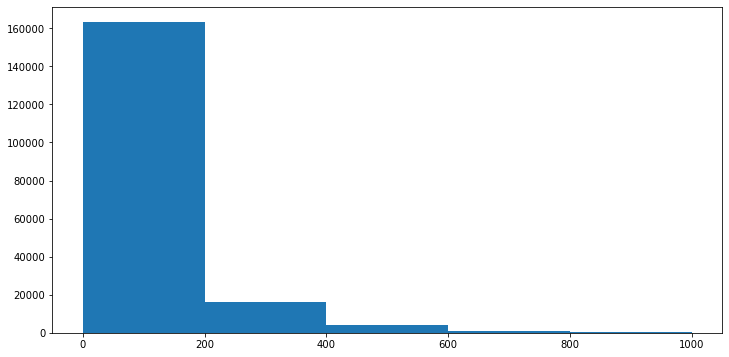

In [42]:
fig = plt.figure(figsize=(12, 6))

plt.hist(X_train_df['X'].str.split().apply(len), range=[0, 1000], bins= 5)
plt.show()

## B2: Tokenization Process

The tokenization process was peformed above. The overall goal of the tokenization process is to determine the prioritized list of words in each row or document of text. Tokenization reduces the amount of data needed to input into the model through steps determined by the user as needed. These steps can include:

 - Remove unusual characters and punctuation such as !@#$%^&*()
 - Perform stemming and/or lemmatization by removing endings to root words such as '..ly', '..ing', etc. Stemming uses the stem of the word, while lemmatization uses the context in which the word is being used. 
 - Remove stopwords which are commonly used words in a language such as "a, the, is, are, etc". This was performed above using Spacys built in stopwords list.

The tokenization process may be modified or skipped based on the need of the overall goal of the analysis.   

## B3: Padding Process

To begin the padding process, the tokens produced were transformed into their integer values found in the dictionary produced using Keras's ```fit_on_texts()``` function. This dictionary was partially show above by showing the first 20 items in the function's word_index dictionary.

The ```text_to_sequences()``` functions peforms transformation by producing an array of integers for each row corresponding with each word in the dictionary. However, the lengths of the arrays vary because the number of tokens in each row vary. In order to fit into the model the arrays shape must be consistant. 

The padding process is used to fix this issue. The dictionary value "0" is saved for padding values. As determined above the maximum length for each sequence is 400. Using Kera's ```pad_sequence()``` function and the hyperparameter ```padding=post``` the integer arrays are padded with 0's until they are length 400. Using post padding ensures tokens are not cut from the data. For arrays with greater than 400 values, these arrays are truncated at lengths of 400.

A single padded sequence is shown below. We can verify the shape of the matrix array by using ```.shape``` to verify the length of 400.

In [43]:
# Change texts into sequence of indexes
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [44]:
# Pad the numerical matric to a max length of 400
X_train = pad_sequences(X_train, maxlen=400, padding='post')
X_test = pad_sequences(X_test, maxlen= 400, padding= 'post')

In [45]:
#Provide code for single padded sequence from training set
print(X_train[8,:])

[    2    24   350    16  1039  1408 18645  8983  1297     2    16     2
   129   448     2   113     6  5023   403     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [46]:
#Provide code for single padded sequence from test set
print(X_test[6,:])

[   56   765 19133    91   215     3    10   176  3552     3   711 11651
  3235   282  5247     3     3   269   511  1107   180   517  3552   732
  6740   457    12  5595   656  3608  2733   282     6   389   942    64
   176   942    91     9   233   502   923   942    15   174   643   484
   176  1105   280    92    88  1443   765    77     4   109   131    25
    17   156  7274  8586   245     7   233   787   363   201   788   211
   429    17   203    48   693  1967    16   203    48   215     3   158
   787  2973    10   942   211   656    48    51     6  1295   923 17277
   189  1067   121   656  1067    48    48   119    43  1087  1515    18
   949     1   626   656    48  1515   756    17     3    43   656    48
   501   788     5   121  1095   627   942   541   446    17    96   208
  5422   208    18  1543  1558     2   116   770   877   127   131    61
    18    17    40   241    61   502  3593   189    75   244    32    12
    50    61   628   205  3349   211    19  1059  3

In [47]:
# Output first 20 results of work_index dictionary
dict(list(word_index.items())[0:20])

{'UNK': 1,
 'i': 2,
 'game': 3,
 'play': 4,
 'like': 5,
 'good': 6,
 'time': 7,
 'great': 8,
 'fun': 9,
 'use': 10,
 'character': 11,
 'new': 12,
 'thing': 13,
 'graphic': 14,
 'look': 15,
 'buy': 16,
 'story': 17,
 'level': 18,
 'find': 19,
 'way': 20}

In [48]:
# Check shape of X_train matrix
X_train.shape

(185388, 400)

In [49]:
# Check shape of X_test matrix
X_test.shape

(46348, 400)

In [50]:
# Create the max input_len for the model
review_len = 400

## B4: Sentiment Categories

There are 5 categories that will be used to determine the sentiment of the model and predictions. These catergories are the stars given for each product review with 1 being the most negative to 5 being the most positive. However, when one hot encoding is performed 6 categories will be used because the values of all 0s is also encoded. No issues should arise because no 0s or missing values were found when checking the target data. 

The activation function 'softmax' will be used in the final dense layer of the model network. Softmax performs calculations to determine the most probable sentiment category for the output. 

## B5: Data Analysis Preparation Steps

The steps used to prepare the data for analysis are as follows:

1. Read the data into a usable format for processing. This was performed above by reading the Amazon .json file and transforming it into a DataFrame
2. Peform data cleaning and exploration by checking for duplicates, missing data, abnormal inputs, etc. and imputing or removing as necessary.
3. Check for abnormal character and replace or remove as necessary. The function loop above performed this automatically using various Regex functions.
4. Split the data into an 80/20 split. The 80% allocated data will be used to train the model and the remaining 20% is used to test the model.
5. Tokenize each row of reviews in the training set. In the tokenization process, lemmatization is also performed.
6. Identify the vocabulary length of the training data in order to determine a word embedding length.
7. Retrieve the word_index of the training data.
8. Perform numerical sequencing of both the training and test data.
9. Perform selected exploration to determine a maximun length of vectors to use in the padding sequence. Use the determine length to pad each sequence.
10. Transform the training and test sets into NumPy arrays.

## B6: Copy of Prepared Dataset

In [51]:
df_x_train = pd.DataFrame(X_train)
df_x_test = pd.DataFrame(X_test)
df_y_train = pd.DataFrame(y_train)
df_y_test = pd.DataFrame(y_test)

In [52]:
df_x_train.iloc[0:1000].to_csv("C:/Users/holtb/Data/WGU Datasets/df_xtrain_sample.csv")
df_x_test.iloc[0:1000,].to_csv("C:/Users/holtb/Data/WGU Datasets/df_xtest_sample.csv")
df_y_train.iloc[0:1000,].to_csv("C:/Users/holtb/Data/WGU Datasets/df_ytrain_sample.csv")
df_y_test.iloc[0:1000,].to_csv("C:/Users/holtb/Data/WGU Datasets/df_ytest_sample.csv")

# Part III: Network Architecture

## C1: Model Output Summary

In [112]:
opt = Adam(learning_rate=0.001)

# Create a model with embeddings
model = Sequential(name="emb_model")
#Input layer
model.add(Embedding(input_dim=vocabulary_size+1, output_dim=50, input_length=review_len, 
                    trainable=True, name = "Embedding"))
#
model.add(GlobalMaxPool1D())
# GRU layer with 64
model.add(Dense(100, activation='relu', name = 'Dense_1'))

model.add(Dropout(0.5))

model.add(Dense(50, activation='relu', name = 'Dense_2'))

model.add(Dropout(0.5))

model.add(Dense(25, activation='relu', name = 'Dense_3'))
# Output layer
model.add(Dense(6, activation='softmax', name = 'Output'))
# Compile model with optimizer and loss functions
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


# Print the summaries of the model with embeddings
model.summary()

Model: "emb_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 400, 50)           7389100   
_________________________________________________________________
global_max_pooling1d_16 (Glo (None, 50)                0         
_________________________________________________________________
Dense_1 (Dense)              (None, 100)               5100      
_________________________________________________________________
dropout_16 (Dropout)         (None, 100)               0         
_________________________________________________________________
Dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_17 (Dropout)         (None, 50)                0         
_________________________________________________________________
Dense_3 (Dense)              (None, 25)                12

In [113]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=2)

history_train = model.fit(X_train, y_train, validation_split = 0.25, epochs=20, callbacks = [early_stopping_monitor])

Epoch 1/20
4346/4346 [==============================] - 203s 46ms/step - loss: 1.1069 - accuracy: 0.5498 - val_loss: 1.0015 - val_accuracy: 0.5829
Epoch 2/20
4346/4346 [==============================] - 203s 47ms/step - loss: 0.9971 - accuracy: 0.5879 - val_loss: 1.0089 - val_accuracy: 0.5864
Epoch 3/20
4346/4346 [==============================] - 204s 47ms/step - loss: 0.9550 - accuracy: 0.6039 - val_loss: 0.9908 - val_accuracy: 0.5949
Epoch 4/20
4346/4346 [==============================] - 223s 51ms/step - loss: 0.9212 - accuracy: 0.6170 - val_loss: 1.0019 - val_accuracy: 0.5859
Epoch 5/20
4346/4346 [==============================] - 235s 54ms/step - loss: 0.8929 - accuracy: 0.6298 - val_loss: 1.0145 - val_accuracy: 0.5854


In [114]:
history_test = model.evaluate(X_test, y_test)

1449/1449 [==============================] - 2s 2ms/step - loss: 1.0180 - accuracy: 0.5844


## C2: Layer Types, Numbers, and Parameters

- Number of Layers: There are eight layers in the sequential model: one input embedding layer, three Dense layers, two Dropout layers, and one Dense output layer.

- Type of Layers:
    - Embedding - The embedding layer is needed to use inputs of sequence matrices (such as the one being used). Without the embedding layer, the inputs would need to be one-hot encoded. This wouldn't be feasible with large datasets as the one-hot encoding matrix would require a huge amount of memory and reduces model efficiency. Additionally, embedding groups similar words into vectors enhancing the model accuracy and efficiency.
    - GlobalMaxPool1D - 
    - Dropout -  
    - Dense - The dense layer is the most simple type of layer, taking in input and adjusting the weight from each input.

- Total number of parameters: There are a total of 2,816,339 parameters in the model with the majority of them occurring in the embedding layer. 

## C3: Hyperparameter Justification

### Activation functions
The activation functions in the model are located in the Dense layers. The first Dense layers contains the relu activation which sets any negative outputs to 0. The output Dense layer contains a 'softmax' activation function. This activation function was selected to predict the most likely category output (target value) from the input. 

### Number of nodes per layer
When creating the architecture for the model, the number of nodes started low and then were increased until the model began to overfit. Additionally, the number of nodes per layer was selected in a way to provide a reasonable runtime for training the model. More nodes could be selected which could improve the accuracy but would require much more time to train the model.

### Loss function
The loss function "categorical_crossentropy" was selected because it is a popular and appropriate loss function to choose for categorical targets.

### Optimizer
The optimizer 'adam' was selected because it is one of the most common and efficient optimizers in machine learning. The Adam optimizer has the following benifits:

- Straightforward to implement.
- Computationally efficient.
- Little memory requirements.
- Invariant to diagonal rescale of the gradients.
- Well suited for problems that are large in terms of data and/or parameters.
- Appropriate for non-stationary objectives.
- Appropriate for problems with very noisy/or sparse gradients.
- Hyper-parameters have intuitive interpretation and typically require little tuning.

(Brownlee, 2021)

Additionally, the learning rate for the optimizer was set to .001. This assists the optimizer with locating the optimal derivative values without "skipping" them while training.

### Stopping criteria
The validation loss was selected to be used as the stopping criteria. If no significant improvements were made in the loss then the model stops training. This helps prevent the model from overfitting because, even if the training loss continues to improve, it won't make a difference unless the validation loss improves as well. 

### Evaluation metric

The evaluation metric selected as the 'accuracy' metric. This metric allows the model to be compared to other models by evaluating the probability of it predicting the correct category.

# Part IV: Model Evaluation

## D1: Stopping Criteria Impact

The stopping criteria defined in the ```model.fit()``` function allows the model to continue training until performance in the selected criteria declines. This allows the model to train multiple epochs without needing to worry about wasting time or resources continuing the training if performance doesn't improve.

## D2: Training Process Visualization

Below is a plot which visualizes the accuracy and the validation accuracy for each epoch trained.

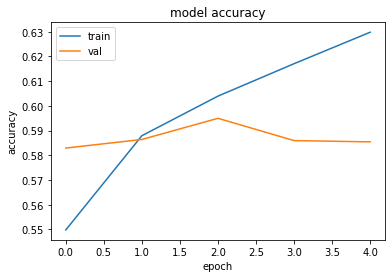

In [148]:
plt.plot(history_train.history['accuracy'])
plt.plot(history_train.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

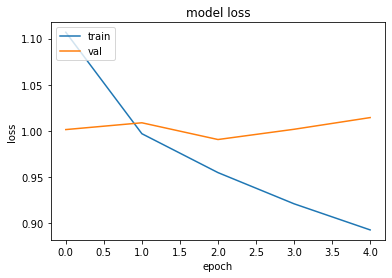

In [149]:
plt.plot(history_train.history['loss'])
plt.plot(history_train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## D3: Model Fitness Assessment

The evaluation metric used to evaluate how well the model can classify the categories was 'accuracy'. The model's accuracy outcome was approximately 62% for training, 58% for validation, and 58% for the testing accuracy. The model ran for 5 epochs and, while the training data accuracy and loss improved, the validation accuracy and loss hover around the same levels. This suggest the model may need more data to train, added complexity, or more focused target categories. 

To address overfitting, dropout layers were added into the model. The dropout layers sets a percentage of the nodes (set to 0.5 in the model) to be randomly set to zero. This forces the model to retrain them on each epoch.

## D4: Predictive Accuracy

As shown below in the classification report, the model had the most success predicting five-star rating reviews at a 73% accuracy. The second highest was the one-star review ratings at only 44%. The model had an accuracy of 58% over all categories of the test set.

In [131]:
# Tranform y_test to DataFrame
y_test_df = pd.DataFrame(y_test)

In [134]:
# Create dictionary of decoder
df_transform = pd.DataFrame({0:[0,0,0,0,0,0], 1:[0,1,0,0,0,0], 2:[0,0,1,0,0,0], 3:[0,0,0,1,0,0], 4:[0,0,0,0,1,0], 5:[0,0,0,0,0,1]})

# Create one hot decoder
def decode(row):
    for c in y_test_df.columns:
        if row[c]==1:
            return c

# Apply decoder to y_test_df
y_test_cat = y_test_df.apply(decode,axis=1)
print(y_test_cat)

0        5
1        4
2        5
3        3
4        5
        ..
46343    4
46344    4
46345    4
46346    5
46347    5
Length: 46348, dtype: int64


In [150]:
# Make predications with X_test
y_pred = model.predict(X_test)
predicted_categories = np.argmax(y_pred, axis=1)

In [151]:
# Transform datatypes
y_pred = y_pred.astype(int)
y_test_arr = y_test_cat.to_numpy()

# Print classification report
print(classification_report(y_test_arr, predicted_categories))

              precision    recall  f1-score   support

           1       0.44      0.59      0.51      3044
           2       0.31      0.07      0.12      2721
           3       0.35      0.35      0.35      5556
           4       0.42      0.38      0.40     11071
           5       0.73      0.79      0.76     23956

    accuracy                           0.58     46348
   macro avg       0.45      0.44      0.43     46348
weighted avg       0.56      0.58      0.57     46348



# Part V: Summary and Recommendations

## E. Code used to save model

In [152]:
model.save("C:/Users/holtb/Documents/GitHub/D213_Advanced_Data_Analytics/model_1")

INFO:tensorflow:Assets written to: C:/Users/holtb/Documents/GitHub/D213_Advanced_Data_Analytics/model_1\assets


INFO:tensorflow:Assets written to: C:/Users/holtb/Documents/GitHub/D213_Advanced_Data_Analytics/model_1\assets


## F. Functionality of the Neural Network and Network Architecture Impact

231,780 customer reviews were input into the model to predict each reviewer's rating based on the text of the review. The neural network took the tokenized reviews and input each review while attempting to "learn" which words/word combinations most accurately predicted the rating. 

The model begins by using embedding to create word vectors. These vectors are trained by predicting what words are most like each other. This reduces the training time of the model but may create accuracy issues due to the loss of context meaning, misspellings, etc. The data continues through the Dense layer nodes adjusting weights as it backpropegated through the model. Once the model creates the weights it deems to most accurately predict the outcomes, the model is created. Test data can then be tested against the training data to check for model accuracy.

While the model didn't perform well, some things that could be improved to create a better-performing model. First, the target categorical data is pretty broadly defined. When reviewing the written reviews, many of the same words and language in one- or two-star reviews and four- or five-star reviews are similar or the same. This may make it difficult for the model to distinguish between these reviews and make accurate predictions. If the categorical variables were combined into negative (1 & 2 stars), neutral(3 stars), and positive (4 & 5 stars) this could make the model much more accurate. Additionally, due to time constraints and resources, a more complex model can be created. While performing experimentation to select a model to use, a model with LSTM and GPU layers was created that had 70% accuracy in the training set and 60% validation and testing set accuracy. While this model was more accurate, it was overfitted and needed adjustments. However, each epoch took 45 minutes to an hour to run requiring much more time than available. 

## G. Course of Action

The purpose of the natural language processing model that was created was to identify customer sentiment on a 5-star rating model. The model can assist in identifying brand awareness and create real-time awareness of sentiment analysis of specific products to make faster and more reliable changes to prodcuts.  While the model currently underperforms as it is, if more resources were provide, I have no doubt that a much more accurate model can be obtained. 


### References

Brownlee, J. (2021, January 12). Gentle introduction to the adam optimization algorithm for deep learning. Machine Learning Mastery. Retrieved March 21, 2022, from https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/ 

Introducing tensorflow feature columns. Google Developers Blog. (n.d.). Retrieved March 21, 2022, from https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html 

https://proceedings.neurips.cc/paper/2018/file/b534ba68236ba543ae44b22bd110a1d6-Paper.pdf

Ups and downs: Modeling the visual evolution of fashion ... (n.d.). Retrieved March 22, 2022, from https://cseweb.ucsd.edu/~jmcauley/pdfs/www16a.pdf 

Yin, Z., & Shin, Y. (n.d.). On the dimensionality of word embedding - list of proceedings. Retrieved March 22, 2022, from https://proceedings.neurips.cc/paper/2018/file/b534ba68236ba543ae44b22bd110a1d6-Paper.pdf 

### Third Party Code

Becker, D. "Introduction to Deep Learning in Python" [MOOC]. Datacamp. https://app.datacamp.com/learn/courses/introduction-to-deep-learning-in-python

Cecchini, D. "Recurrent Neural Networks for Language Modeling in Python" [MOOC]. Datacamp. https://app.datacamp.com/learn/courses/recurrent-neural-networks-for-language-modeling-in-python

Chollet, F., & others. (2015). Keras. GitHub. Retrieved from https://github.com/fchollet/keras

Harris, C.R., Millman, K.J., van der Walt, S.J. et al. Array programming with NumPy. Nature 585, 357–362 (2020). DOI: 0.1038/s41586-020-2649-2. (Publisher link)

Honnibal, M., & Montani, I. (2017). spaCy 2: Natural language understanding with Bloom embeddings, convolutional neural networks and incremental parsing.

Martín Abadi, Ashish Agarwal, Paul Barham, Eugene Brevdo,
Zhifeng Chen, Craig Citro, Greg S. Corrado, Andy Davis,
Jeffrey Dean, Matthieu Devin, Sanjay Ghemawat, Ian Goodfellow,
Andrew Harp, Geoffrey Irving, Michael Isard, Rafal Jozefowicz, Yangqing Jia,
Lukasz Kaiser, Manjunath Kudlur, Josh Levenberg, Dan Mané, Mike Schuster,
Rajat Monga, Sherry Moore, Derek Murray, Chris Olah, Jonathon Shlens,
Benoit Steiner, Ilya Sutskever, Kunal Talwar, Paul Tucker,
Vincent Vanhoucke, Vijay Vasudevan, Fernanda Viégas,
Oriol Vinyals, Pete Warden, Martin Wattenberg, Martin Wicke,
Yuan Yu, and Xiaoqiang Zheng.
TensorFlow: Large-scale machine learning on heterogeneous systems,
2015. Software available from tensorflow.org.

J. McAuley, R. He. Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering, WWW, 2016

J. D. Hunter, "Matplotlib: A 2D Graphics Environment", Computing in Science & Engineering, vol. 9, no. 3, pp. 90-95, 2007

Python Software Foundation. Python Language Reference, version 3.7. Available at http://www.python.org